In [1]:
%load_ext autoreload
%autoreload 0

In [2]:
%autoreload

In [3]:
import xarray as xr
import sqlite3
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import torch
import pyro
import scipy as sp

import lib.plot
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from lib.pandas_util import idxwhere

import sfacts as sf

from tqdm import tqdm

from scipy.spatial.distance import pdist, squareform
import statsmodels.formula.api as smf

# from lib.project_style import color_palette, major_allele_frequency_bins
# from lib.project_data import metagenotype_db_to_xarray
# from lib.plot import ordination_plot, mds_ordination, nmds_ordination
# import lib.plot
# from lib.plot import construct_ordered_pallete
# from lib.pandas_util import idxwhere

In [4]:
mgen_path = {
    '104345': 'data/ucfmt.sp-104345.metagenotype.filt-poly05-cvrg05.nc',
    '102506': 'data/zshi.sp-102506.metagenotype.filt-poly05-cvrg25.nc',
    '102492': 'data/zshi.sp-102492.metagenotype.filt-poly05-cvrg25.nc',
    '102163': 'data/zshi.sp-102163.metagenotype.filt-poly05-cvrg25.nc',
    '102556': 'data/zshi.sp-102556.metagenotype.filt-poly05-cvrg25.nc',
}

gtpro = {}
ani = {}

for species_id in mgen_path:
    ani[species_id] = pd.read_table(f'raw/ani_zshi/{species_id}_ani.tsv', names=['genomeA', 'genomeB', 'ani'], index_col=['genomeA', 'genomeB']).squeeze()
    _mgen = xr.open_dataarray(mgen_path[species_id])
    _position = _mgen.position.astype(int)
    _mgen.close()
    _gtpro = sf.data.Metagenotypes.load(f'data/gtprodb.sp-{species_id}.genotype.nc').mlift('sel', position=_position).to_estimated_genotypes(pseudo=0)
    gtpro[species_id] = pd.DataFrame(squareform(pdist(_gtpro.values, metric='hamming')), index=_gtpro.strain, columns=_gtpro.strain).stack().rename_axis(['genomeA', 'genomeB']).loc[ani[species_id].index]


In [5]:
outputs = {}

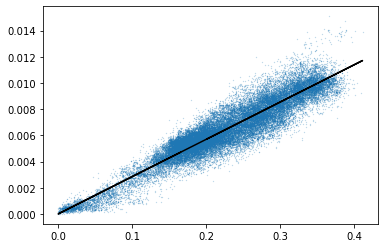

In [6]:
species_id = '104345'

d = pd.DataFrame(dict(hamming=gtpro[species_id], avg_nucl_dev=1 - ani[species_id] / 100))
lr = smf.ols('avg_nucl_dev ~ hamming - 1', data=d).fit()
d['predict'] = lr.predict()

plt.scatter('hamming', 'avg_nucl_dev', data=d, s=0.05, alpha=0.5)
plt.plot('hamming', 'predict', data=d, color='k')

lr.summary()

outputs[species_id] = d, lr

hamming    0.077567
dtype: float64


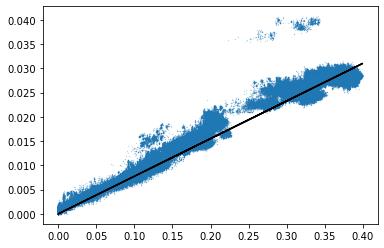

In [7]:
species_id = '102506'

d = pd.DataFrame(dict(hamming=gtpro[species_id], avg_nucl_dev=1 - ani[species_id] / 100))
lr = smf.ols('avg_nucl_dev ~ hamming - 1', data=d).fit()
d['predict'] = lr.predict()

plt.scatter('hamming', 'avg_nucl_dev', data=d, s=0.05, alpha=0.5)
plt.plot('hamming', 'predict', data=d, color='k')

print(lr.params)
lr.summary()

outputs[species_id] = d, lr

hamming    0.10687
dtype: float64


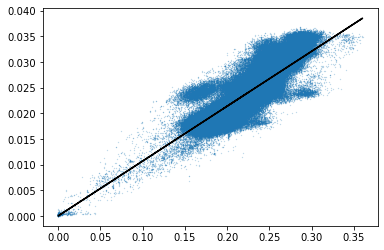

In [8]:
species_id = '102492'

d = pd.DataFrame(dict(hamming=gtpro[species_id], avg_nucl_dev=1 - ani[species_id] / 100))
lr = smf.ols('avg_nucl_dev ~ hamming - 1', data=d).fit()
d['predict'] = lr.predict()

plt.scatter('hamming', 'avg_nucl_dev', data=d, s=0.05, alpha=0.5)
plt.plot('hamming', 'predict', data=d, color='k')

print(lr.params)
lr.summary()

outputs[species_id] = d, lr

hamming    0.039304
dtype: float64


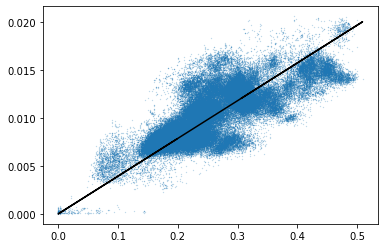

In [9]:
species_id = '102163'

d = pd.DataFrame(dict(hamming=gtpro[species_id], avg_nucl_dev=1 - ani[species_id] / 100))
lr = smf.ols('avg_nucl_dev ~ hamming - 1', data=d).fit()
d['predict'] = lr.predict()

plt.scatter('hamming', 'avg_nucl_dev', data=d, s=0.05, alpha=0.5)
plt.plot('hamming', 'predict', data=d, color='k')

print(lr.params)
lr.summary()

outputs[species_id] = d, lr

hamming    0.059479
dtype: float64


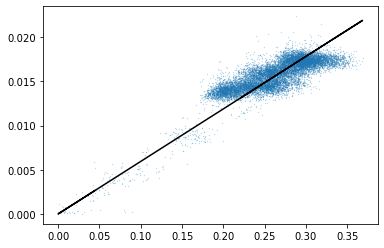

In [10]:
species_id = '102556'

d = pd.DataFrame(dict(hamming=gtpro[species_id], avg_nucl_dev=1 - ani[species_id] / 100))
lr = smf.ols('avg_nucl_dev ~ hamming - 1', data=d).fit()
d['predict'] = lr.predict()

plt.scatter('hamming', 'avg_nucl_dev', data=d, s=0.05, alpha=0.5)
plt.plot('hamming', 'predict', data=d, color='k')

print(lr.params)
lr.summary()

outputs[species_id] = d, lr

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  
/opt/conda

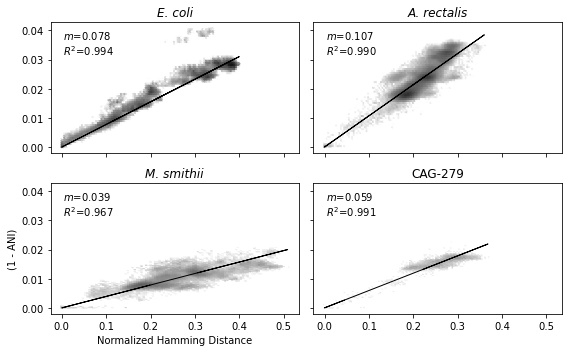

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(8, 5), sharex=True, sharey=True)

species_id_to_name = {
    '102506': ('E. coli', 'italic'),
    '102492': ('A. rectalis', 'italic'),
    '102163': ('M. smithii', 'italic'),
    '102556': ('CAG-279', 'normal'),
    
}

for species_id, ax in zip(['102506', '102492', '102163', '102556'], axs.flatten()):
    d, lr = outputs[species_id]
#     ax.scatter('hamming', 'avg_nucl_dev', data=d, s=0.05, alpha=0.4)
    x = ax.hexbin('hamming', 'avg_nucl_dev', data=d, cmap='Greys', norm=mpl.colors.SymLogNorm(linthresh=1), rasterized=True, vmin=0, vmax=20000)
    ax.plot('hamming', 'predict', data=d, color='k', lw=1)
    ax.set_title(species_id_to_name[species_id][0], fontdict=dict(style=species_id_to_name[species_id][1]))
    ax.annotate(f'$m$={lr.params[0]:0.3f}\n$R^2$={lr.rsquared:0.3f}', xy=(0.05, 0.75), xycoords='axes fraction')

axs[1,0].set_ylabel('(1 - ANI)')
axs[1,0].set_xlabel('Normalized Hamming Distance')

fig.tight_layout()

fig.savefig('fig/genotype_distance_ani_relationship.pdf')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  del sys.path[0]


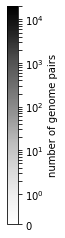

In [12]:
fig, ax = plt.subplots()

species_id_to_name = {
    '102506': ('E. coli', 'italic'),
    '102492': ('A. rectalis', 'italic'),
    '102163': ('M. smithii', 'italic'),
    '102556': ('CAG-279', 'normal'),
    
}

d, lr = outputs['102506']
#     ax.scatter('hamming', 'avg_nucl_dev', data=d, s=0.05, alpha=0.4)
plt.hexbin('hamming', 'avg_nucl_dev', data=d, cmap='Greys', norm=mpl.colors.SymLogNorm(linthresh=1), rasterized=True, vmin=0, vmax=20000)
plt.colorbar(label='number of genome pairs')

ax = fig.gca()
ax.set_visible(False)

fig.savefig('fig/genotype_distance_ani_relationship_cbar.pdf')